In [1]:
import gc
import os
import itertools
import pickle
import re
import time
from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from functools import reduce
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics, model_selection, preprocessing, linear_model, ensemble, decomposition, tree
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


import sys
sys.path.append('../../')
from utils import *

## Prepro: change names to numbers

In [2]:
train_feats = pd.read_csv('../../kaggle feat_eng/silver_bullet_192feat_corrected.csv')

train_feats.replace([np.inf, -np.inf], np.nan, inplace=True)
cols = train_feats.columns

counter = 0
new_columns = {}
for col in cols:
    if col != 'id' and col != 'score':
        new_columns[col] = counter
        counter += 1

train_feats.rename(columns=new_columns, inplace=True)

In [3]:
target_col = ['score']
drop_cols = ['id']
train_cols = [col for col in train_feats.columns if col not in target_col + drop_cols]

## Clf

In [4]:
def objective(trial,train_x,train_y,val_x,val_y,RANDOM_STATE=41):

    params = {
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.4,0.7,1.0]),
        'colsample_bynode': trial.suggest_categorical('colsample_bynode', [0.4,0.7,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.7,1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True), #trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [9,11,13,15,17,20]),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [7,9,11,13,15,17,20]),
        'num_leaves': trial.suggest_int('num_leaves', 10, 38, step=4),
        'n_estimators': trial.suggest_int('n_estimators', 10, 100, step=10),
    }

    all_params = {
        "objective": "binary",
        "metric": "average_precision",
        'random_state': RANDOM_STATE,
        "verbosity": -1,
        "n_jobs": -1,
        **params
    }

    model = lgb.LGBMClassifier(**all_params)
    
    model.fit(train_x, train_y.values.ravel())#, eval_set=[(val_x, val_y)], #verbose=False,
    
    preds = model.predict_proba(val_x)[:,1]
    
    rmse = metrics.average_precision_score(val_y, preds)
    
    return rmse

In [5]:
score_thresh = 2.5

In [6]:
secondary_model_data = train_feats.copy()
secondary_model_data['score'] = (secondary_model_data['score']<=score_thresh).astype(int)

In [7]:
def lgb_calc_OOF(x_train, y_train, x_valid, y_valid, iter, split, RANDOM_STATE=42, save=False):
    # split into two validations
    x_valid1, x_valid2, y_valid1, y_valid2 = train_test_split(x_valid, y_valid, test_size=0.5, random_state=RANDOM_STATE, shuffle=False)

    '''Use v1, test on v2'''

    # Bayesian Opt using v1
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, x_train, y_train, x_valid1, y_valid1, RANDOM_STATE), n_trials=20)
    best_trial1 = study.best_trial.params

    # Get best params
    best_params = {
        "objective": "binary",
        "metric": "average_precision",
        'random_state': RANDOM_STATE,
        "verbosity": -1,
        "n_jobs": -1,
        **best_trial1
    }
        
    model = lgb.LGBMClassifier(**best_params)
    model.fit(x_train, y_train.values.ravel())
    if save:
        model.booster_.save_model(f'./low_lgb_thresh25/lgb_iter{iter}_split{split}_val1.txt')

    # Predict on v2
    valid2_predict = model.predict_proba(x_valid2)[:,1]


    '''Use v2, test on v1'''

    # Bayesian Opt using v2
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, x_train, y_train, x_valid2, y_valid2,RANDOM_STATE), n_trials=20)
    best_trial2 = study.best_trial.params

    # Get best params
    best_params = {
        "objective": "binary",
        "metric": "average_precision",
        'random_state': RANDOM_STATE,
        "verbosity": -1,
        "n_jobs": -1,
        **best_trial2
    }
        
    model = lgb.LGBMClassifier(**best_params)
    model.fit(x_train, y_train.values.ravel())
    if save:
        model.booster_.save_model(f'./low_lgb_thresh25/lgb_iter{iter}_split{split}_val2.txt')

    # Predict on v1
    valid1_predict = model.predict_proba(x_valid1)[:,1]

    # Return OOFs
    return np.concatenate([valid1_predict,valid2_predict])

In [8]:
OOF_CLF_PRED = np.zeros(len(secondary_model_data))

models_dict = {}

iterations = 5
n_splits = 4

for i in range(iterations):

    kf = model_selection.KFold(n_splits=n_splits, random_state=41 + i, shuffle=True)
    j = 0
    for fold, (train_idx, valid_idx) in enumerate(kf.split(secondary_model_data)):
        
        X_train, y_train = secondary_model_data.iloc[train_idx][train_cols], secondary_model_data.iloc[train_idx][target_col]
        X_valid, y_valid = secondary_model_data.iloc[valid_idx][train_cols], secondary_model_data.iloc[valid_idx][target_col]

        valid_predict = lgb_calc_OOF(X_train, y_train, X_valid, y_valid, i, j, RANDOM_STATE=41 + i, save=True)

        OOF_CLF_PRED[valid_idx] += valid_predict / iterations
        j+=1
        # models_dict[f'{fold}_{i}'] = model

[I 2023-12-27 13:18:04,668] A new study created in memory with name: no-name-8820f97d-32e7-4c8a-a33c-98b585792ed4


[I 2023-12-27 13:18:04,898] Trial 0 finished with value: 0.6531171390559632 and parameters: {'reg_lambda': 0.2718699037494286, 'reg_alpha': 0.001625106989085432, 'colsample_bytree': 0.7, 'colsample_bynode': 1.0, 'subsample': 0.7, 'learning_rate': 0.0008998287795858408, 'max_depth': 13, 'min_child_samples': 7, 'num_leaves': 14, 'n_estimators': 90}. Best is trial 0 with value: 0.6531171390559632.
[I 2023-12-27 13:18:05,077] Trial 1 finished with value: 0.441479832266751 and parameters: {'reg_lambda': 0.00020310480159511048, 'reg_alpha': 4.291963092669482, 'colsample_bytree': 1.0, 'colsample_bynode': 1.0, 'subsample': 0.7, 'learning_rate': 1.2682258427853495e-05, 'max_depth': 20, 'min_child_samples': 11, 'num_leaves': 14, 'n_estimators': 100}. Best is trial 0 with value: 0.6531171390559632.
[I 2023-12-27 13:18:05,186] Trial 2 finished with value: 0.6483842536192618 and parameters: {'reg_lambda': 0.21238746273832898, 'reg_alpha': 0.044629719461477424, 'colsample_bytree': 0.7, 'colsample_by

In [9]:
print('OOF AUC-PR LGBM = {:.5f}'.format(metrics.average_precision_score(secondary_model_data[target_col], 
                                                                   OOF_CLF_PRED)))

OOF AUC-PR LGBM = 0.51635


In [10]:
import pickle

with open('low_lgb_thresh25/OOF_low_lgb.pkl', 'wb') as f:
    pickle.dump(OOF_CLF_PRED, f)

Text(0.5, 1.0, 'AUC-PR=0.5163517227369822')

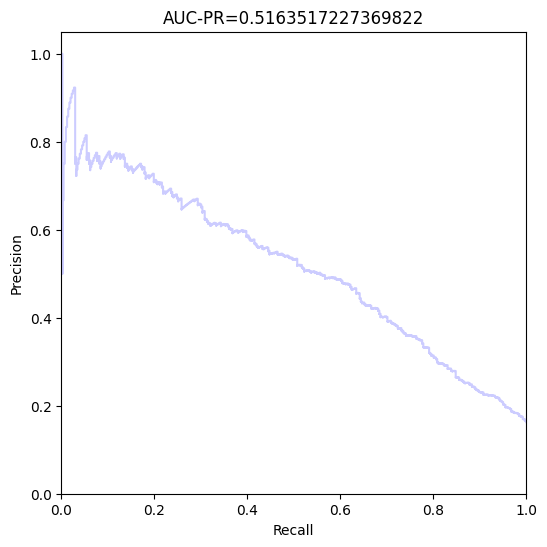

In [11]:
precision, recall, _ = metrics.precision_recall_curve(secondary_model_data[target_col], OOF_CLF_PRED)
average_precision = metrics.average_precision_score(secondary_model_data[target_col], OOF_CLF_PRED)

plt.figure(figsize=(6,6))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'AUC-PR={average_precision}')

In [12]:
fpr, tpr, thresholds = metrics.roc_curve(secondary_model_data[target_col], OOF_CLF_PRED)
roc_auc = metrics.auc(fpr, tpr)

best_argmax = np.argmax(np.sqrt(tpr*(1-fpr)))
best_thr = thresholds[best_argmax]
print('Best argmax: ', best_argmax)
print('Best threshold: ', best_thr)

Best argmax:  362
Best threshold:  0.16322278684269798


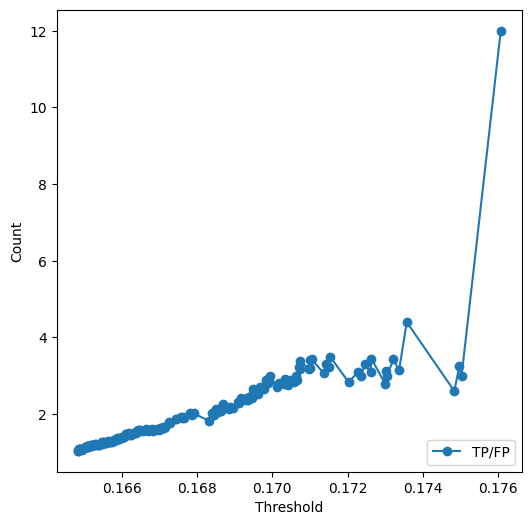

In [13]:
# Plot number of true positives and number of false positives as a function of the decision threshold for the first 50 thresholds, not fpr, but actual false positive count
tps = []
fps = []
ratios = []
max_ = 200

for thr in thresholds[3:max_]:
    _, fp, _, tp = metrics.confusion_matrix(secondary_model_data[target_col], OOF_CLF_PRED>=thr).ravel()
    ratios.append(tp/fp)
    tps.append(tp)
    fps.append(fp)

plt.figure(figsize=(6,6))
plt.plot(thresholds[3:max_], ratios, label='TP/FP', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Count')
plt.legend(loc="lower right")

In [14]:
print(fps[10])
print(tps[10])

9
31


## Low reg

In [15]:
secondary_model_data = train_feats[train_feats['score']<=score_thresh].copy()

In [16]:
def objective(trial,train_x,train_y,val_x,val_y,RANDOM_STATE=41):

    params = {
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 10.0, log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.4,0.7,1.0]),
        'colsample_bynode': trial.suggest_categorical('colsample_bynode', [0.4,0.7,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.7,1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True), #trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [5,9,11]),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [5,7,9,11]),
        'num_leaves': trial.suggest_int('num_leaves', 8, 20, step=4),
        'n_estimators': trial.suggest_int('n_estimators', 5, 55, step=10),
    }

    all_params = {
        "objective": "rmse",
        "metric": "rmse",
        'random_state': RANDOM_STATE,
        "verbosity": -1,
        "n_jobs": -1,
        **params
    }

    model = lgb.LGBMRegressor(**all_params)
    
    model.fit(train_x, train_y)#, eval_set=[(val_x, val_y)], #verbose=False,
    
    preds = model.predict(val_x)
    
    rmse = mean_squared_error(val_y, preds, squared=False)
    
    return rmse

In [17]:
def lgb_calc_OOF(x_train, y_train, x_valid, y_valid, iter, split, RANDOM_STATE=42, save=False):
    # split into two validations
    x_valid1, x_valid2, y_valid1, y_valid2 = train_test_split(x_valid, y_valid, test_size=0.5, random_state=RANDOM_STATE, shuffle=False)

    '''Use v1, test on v2'''

    # Bayesian Opt using v1
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, x_train, y_train, x_valid1, y_valid1,RANDOM_STATE), n_trials=20)
    best_trial1 = study.best_trial.params

    # Get best params
    best_params = {
        "objective": "rmse",
        "metric": "rmse",
        'random_state': RANDOM_STATE,
        "verbosity": -1,
        "n_jobs": -1,
        **best_trial1
    }
        
    model = lgb.LGBMRegressor(**best_params)
    model.fit(x_train, y_train)
    if save:
        model.booster_.save_model(f'./low_lgb_reg_thresh25/lgb_iter{iter}_split{split}_val1.txt')

    # Predict on v2
    valid2_predict = model.predict(x_valid2)


    '''Use v2, test on v1'''

    # Bayesian Opt using v2
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, x_train, y_train, x_valid2, y_valid2,RANDOM_STATE), n_trials=20)
    best_trial2 = study.best_trial.params

    # Get best params
    best_params = {
        "objective": "rmse",
        "metric": "rmse",
        'random_state': RANDOM_STATE,
        "verbosity": -1,
        "n_jobs": -1,
        **best_trial2
    }

    model = lgb.LGBMRegressor(**best_params)
    model.fit(x_train, y_train)
    if save:
        model.booster_.save_model(f'./low_lgb_reg_thresh25/lgb_iter{iter}_split{split}_val2.txt')

    # Predict on v1
    valid1_predict = model.predict(x_valid1)

    # Return OOFs
    return np.concatenate([valid1_predict,valid2_predict])

In [18]:
OOF_LOW_SCORE = np.zeros(len(secondary_model_data))

models_dict = {}

iterations = 5
n_splits = 4

for i in range(iterations):

    kf = model_selection.KFold(n_splits=n_splits, random_state=41 + i, shuffle=True)
    j = 0
    for fold, (train_idx, valid_idx) in enumerate(kf.split(secondary_model_data)):
        
        X_train, y_train = secondary_model_data.iloc[train_idx][train_cols], secondary_model_data.iloc[train_idx][target_col]
        X_valid, y_valid = secondary_model_data.iloc[valid_idx][train_cols], secondary_model_data.iloc[valid_idx][target_col]

        valid_predict = lgb_calc_OOF(X_train, y_train, X_valid, y_valid, i, j, RANDOM_STATE=41 + i, save=True)

        OOF_LOW_SCORE[valid_idx] += valid_predict / iterations
        j+=1

[I 2023-12-27 13:20:39,232] A new study created in memory with name: no-name-76b97603-9b49-4d44-bdb1-13329c18b8be
[I 2023-12-27 13:20:39,256] Trial 0 finished with value: 0.5085426957676012 and parameters: {'reg_lambda': 0.0010309128444767736, 'reg_alpha': 2.2101645362971e-05, 'colsample_bytree': 0.7, 'colsample_bynode': 0.4, 'subsample': 0.4, 'learning_rate': 1.1955002768014396e-05, 'max_depth': 9, 'min_child_samples': 11, 'num_leaves': 16, 'n_estimators': 5}. Best is trial 0 with value: 0.5085426957676012.
[I 2023-12-27 13:20:39,329] Trial 1 finished with value: 0.508206290317873 and parameters: {'reg_lambda': 0.010315147622112721, 'reg_alpha': 0.00030720108021299315, 'colsample_bytree': 1.0, 'colsample_bynode': 0.4, 'subsample': 0.4, 'learning_rate': 0.00012316422317414246, 'max_depth': 5, 'min_child_samples': 5, 'num_leaves': 12, 'n_estimators': 45}. Best is trial 1 with value: 0.508206290317873.
[I 2023-12-27 13:20:39,366] Trial 2 finished with value: 0.5084636142063456 and parame

In [19]:
print('OOF metric LGBM = {:.5f}'.format(metrics.mean_squared_error(secondary_model_data[target_col], 
                                                                   OOF_LOW_SCORE,
                                                                   squared=False)))

OOF metric LGBM = 0.52838


In [20]:
secondary_model_data['low score'] = OOF_LOW_SCORE

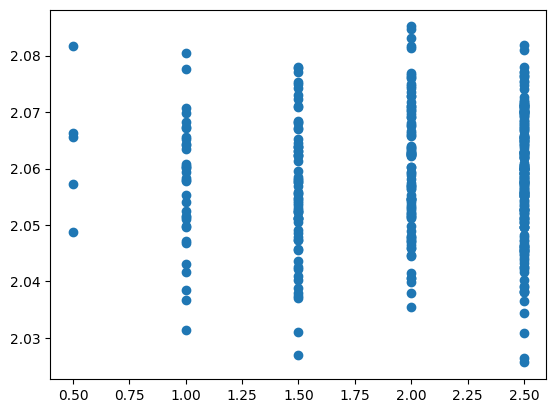

In [21]:
plt.plot(secondary_model_data['score'], secondary_model_data['low score'], 'o')

## Putting all together

In [22]:
with open('../regressors_for_192feats_corr/base_lgb/OOF_base_lgb.pkl', 'rb') as f:
    OOF_REG = pickle.load(f)

In [23]:
train_scores = pd.read_csv('../../data/train_scores.csv')
train_scores['lgb score'] = OOF_REG
train_scores['clf pred'] = OOF_CLF_PRED>thresholds[10]

In [24]:
train_scores = train_scores.merge(secondary_model_data[['id', 'low score']], on='id', how='left')

In [25]:
print('OOF metric LGBM = {:.5f}'.format(metrics.mean_squared_error(train_scores[target_col],
                                                                   train_scores['lgb score'],
                                                                   squared=False)))

OOF metric LGBM = 0.60955


In [26]:
x_temp = train_scores[train_scores['clf pred']==1]

print('OOF metric LGBM = {:.5f}'.format(metrics.mean_squared_error(x_temp[target_col],
                                                                   x_temp['lgb score'],
                                                                   squared=False)))

OOF metric LGBM = 0.70300


In [27]:
x_temp = train_scores[train_scores['clf pred']==1].fillna(1.4)

print('OOF metric LGBM after replacement = {:.5f}'.format(metrics.mean_squared_error(x_temp[target_col], 
                                                                   x_temp['low score'],
                                                                   squared=False)))

OOF metric LGBM after replacement = 1.04716
